In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import os, sys, time, json, glob

import numpy as np
import matplotlib.pyplot as plt

import large_image

import histomicstk.preprocessing.color_normalization as htk_cnorm
import histomicstk.utils as htk_utils

from dask.distributed import Client

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 1080x1080 with 0 Axes>

In [5]:
c = Client('localhost:8786')
display(c)

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 7 Cores: 7 Memory: 59.11 GB


In [49]:
DATA_ROOT_DIR = '/media/nvme/Projects/emory/lymphoma/cmyc'

slide_list = [
    '0118_CMYC_01.ndpi',   # 1 GB
    '0023_CMYC_01.svs',    # 2 GB
    '0038_CMYC_01.svs',    # 2.7 GB
    '0109_CMYC_01.ndpi',   # 819 MB
    '0114_CMYC_01.ndpi',   # 772 MB 
] 

ref_slide_path = os.path.join(DATA_ROOT_DIR, slide_list[1])
print(ref_slide_path)

# get slide tile source
ts = large_image.getTileSource(ref_slide_path)

ts_metadata = ts.getMetadata()

is_wsi = ts_metadata['magnification'] is not None
assert(is_wsi)

print('Metadata :')
print(json.dumps(ts_metadata, indent = 2))

# check num tiles
mag = 20
w = 1024

it_kwargs = {
    'tile_size': {'width': w},
    'scale': {'magnification': mag},
    # 'resample': True
}

print('Tile iterator kwargs')
print(json.dumps(it_kwargs, indent = 2))

num_tiles_est = int((ts_metadata['sizeX'] * ts_metadata['sizeY']) / ((ts_metadata['magnification'] / mag)**2 * w**2))
print('Estimated number of tiles = {}'.format(num_tiles_est))

num_tiles = ts.getSingleTile(**it_kwargs)['iterator_range']['position']
print("Number of tiles from ts.getSingleTile(**it_kwargs)['iterator_range']['position'] = {}".format(num_tiles))

tile_info = ts.getSingleTile(**it_kwargs)
print('TileInfo: ')
pprint.pprint(tile_info)
    
num_tiles = 0
sizes = {}
for tile_info in ts.tileIterator(**it_kwargs):
    sz = (tile_info['width'], tile_info['height'])
    if sz not in sizes:
        sizes[sz] = 1
    else:
        sizes[sz] += 1
    num_tiles += 1
print('Number of tiles by computed summing counter in tile iterator = {}'.format(num_tiles))

print('Tile size counts :')
print(sizes)

/media/nvme/Projects/emory/lymphoma/cmyc/0023_CMYC_01.svs
Metadata :
{
  "magnification": 40.0, 
  "levels": 10, 
  "tileHeight": 240, 
  "tileWidth": 240, 
  "sizeX": 67727, 
  "sizeY": 73738, 
  "mm_y": 0.0002519, 
  "mm_x": 0.0002519
}
Tile iterator kwargs
{
  "tile_size": {
    "width": 1024
  }, 
  "scale": {
    "magnification": 20
  }
}
Estimated number of tiles = 1190
Number of tiles from ts.getSingleTile(**it_kwargs)['iterator_range']['position'] = 4891
TileInfo: 
{'format': None,
 'gheight': 1024.0,
 'gwidth': 1024.0,
 'gx': 0.0,
 'gy': 0.0,
 'height': 1024,
 'iterator_range': {'level_x_max': 67,
                    'level_x_min': 0,
                    'level_y_max': 73,
                    'level_y_min': 0,
                    'position': 4891,
                    'region_x_max': 67,
                    'region_y_max': 73},
 'level': 9,
 'level_x': 0,
 'level_y': 0,
 'magnification': 40.0,
 'mm_x': 0.0002519,
 'mm_y': 0.0002519,
 'tile': None,
 'tile_overlap': {'bottom': 0,

In [44]:
wsi_files = glob.glob(os.path.join(DATA_ROOT_DIR, '*.*'))
bad_count = 0

for f in wsi_files:
    
    ts = large_image.getTileSource(f)

    ts_metadata = ts.getMetadata()

    # check num tiles
    mag = 20
    w = 1024

    it_kwargs = {
        'tile_size': {'width': w},
        'scale': {'magnification': mag},
        'resample:', True
    }

    num_tiles_est = int((ts_metadata['sizeX'] * ts_metadata['sizeY']) / ((ts_metadata['magnification'] / mag)**2 * w**2))

    tile_info = ts.getSingleTile(**it_kwargs)
    num_tiles = ts.getSingleTile(**it_kwargs)['iterator_range']['position']

    print('TileInfo: ')
    pprint.pprint(tile_info)
    
    if abs(1.0 - (num_tiles / num_tiles_est)) > 0.2:
        print(f, num_tiles_est, num_tiles)
        print('Metadata :')
        print(json.dumps(ts_metadata, indent = 2))
        print('TileInfo: ')
        pprint.pprint(tile_info)
        bad_count += 1
        
print('Bad count = {}'.format(bad_count))

('/media/nvme/Projects/emory/lymphoma/cmyc/0055_CMYC_01.svs', 2524, 10168)
Metadata :
{
  "magnification": 40.0, 
  "levels": 11, 
  "tileHeight": 240, 
  "tileWidth": 240, 
  "sizeX": 167327, 
  "sizeY": 63288, 
  "mm_y": 0.0002519, 
  "mm_x": 0.0002519
}
TileInfo: 
{'format': None,
 'gheight': 1024.0,
 'gwidth': 1024.0,
 'gx': 0.0,
 'gy': 0.0,
 'height': 1024,
 'iterator_range': {'level_x_max': 164,
                    'level_x_min': 0,
                    'level_y_max': 62,
                    'level_y_min': 0,
                    'position': 10168,
                    'region_x_max': 164,
                    'region_y_max': 62},
 'level': 10,
 'level_x': 0,
 'level_y': 0,
 'magnification': 40.0,
 'mm_x': 0.0002519,
 'mm_y': 0.0002519,
 'tile': None,
 'tile_overlap': {'bottom': 0, 'left': 0, 'right': 0, 'top': 0},
 'tile_position': {'level_x': 0,
                   'level_y': 0,
                   'position': 0,
                   'region_x': 0,
                   'region_y': 0},
 '

('/media/nvme/Projects/emory/lymphoma/cmyc/0043_CMYC_01.svs', 806, 3315)
Metadata :
{
  "magnification": 40.0, 
  "levels": 10, 
  "tileHeight": 240, 
  "tileWidth": 240, 
  "sizeX": 65736, 
  "sizeY": 51486, 
  "mm_y": 0.0002519, 
  "mm_x": 0.0002519
}
TileInfo: 
{'format': None,
 'gheight': 1024.0,
 'gwidth': 1024.0,
 'gx': 0.0,
 'gy': 0.0,
 'height': 1024,
 'iterator_range': {'level_x_max': 65,
                    'level_x_min': 0,
                    'level_y_max': 51,
                    'level_y_min': 0,
                    'position': 3315,
                    'region_x_max': 65,
                    'region_y_max': 51},
 'level': 9,
 'level_x': 0,
 'level_y': 0,
 'magnification': 40.0,
 'mm_x': 0.0002519,
 'mm_y': 0.0002519,
 'tile': None,
 'tile_overlap': {'bottom': 0, 'left': 0, 'right': 0, 'top': 0},
 'tile_position': {'level_x': 0,
                   'level_y': 0,
                   'position': 0,
                   'region_x': 0,
                   'region_y': 0},
 'width':

('/media/nvme/Projects/emory/lymphoma/cmyc/0057_CMYC_01.svs', 3521, 14268)
Metadata :
{
  "magnification": 40.0, 
  "levels": 11, 
  "tileHeight": 240, 
  "tileWidth": 240, 
  "sizeX": 167327, 
  "sizeY": 88269, 
  "mm_y": 0.0002519, 
  "mm_x": 0.0002519
}
TileInfo: 
{'format': None,
 'gheight': 1024.0,
 'gwidth': 1024.0,
 'gx': 0.0,
 'gy': 0.0,
 'height': 1024,
 'iterator_range': {'level_x_max': 164,
                    'level_x_min': 0,
                    'level_y_max': 87,
                    'level_y_min': 0,
                    'position': 14268,
                    'region_x_max': 164,
                    'region_y_max': 87},
 'level': 10,
 'level_x': 0,
 'level_y': 0,
 'magnification': 40.0,
 'mm_x': 0.0002519,
 'mm_y': 0.0002519,
 'tile': None,
 'tile_overlap': {'bottom': 0, 'left': 0, 'right': 0, 'top': 0},
 'tile_position': {'level_x': 0,
                   'level_y': 0,
                   'position': 0,
                   'region_x': 0,
                   'region_y': 0},
 '

0.625
(1152, 1058, 3)


/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


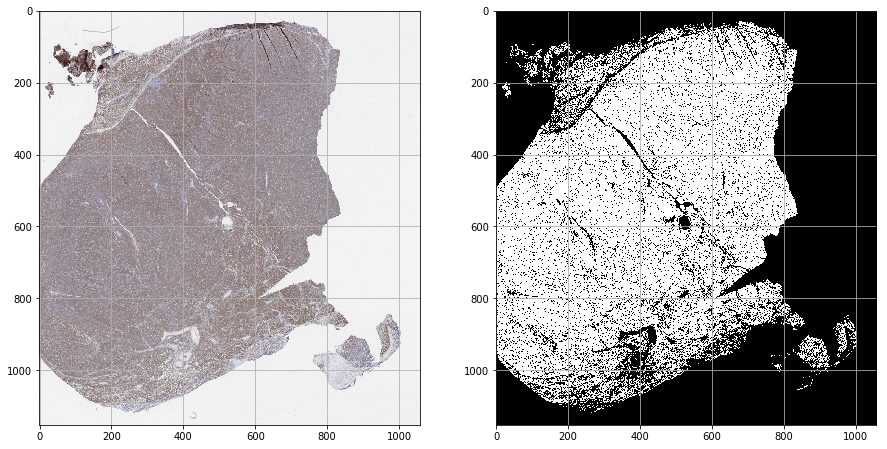

In [7]:
# check foreground segmentation at low-resolution
maxSize = max(ts_metadata['sizeX'], ts_metadata['sizeY'])

fgnd_seg_mag = ts_metadata['magnification'] / 2**np.floor(np.log2(maxSize / 1024))

print fgnd_seg_mag

scale_lres = {'magnification': fgnd_seg_mag}
im_lres, _ = ts.getRegion(
    scale=scale_lres,
    format=large_image.tilesource.TILE_FORMAT_NUMPY,    
)

im_lres = im_lres[:, :, :3]

print im_lres.shape

im_fgnd_mask_lres = htk_utils.simple_mask(im_lres)

plt.subplot(1, 2, 1)
plt.imshow(im_lres)

plt.subplot(1, 2, 2)
plt.imshow(im_fgnd_mask_lres) 

In [ ]:
sample_fraction = 0.01
magnification = 20

start_time = time.time()

ref_mu_lab, ref_sigma_lab = htk_cnorm.reinhard_stats(ref_slide_path, 0.01, magnification=magnification)

rstats_time = time.time() - start_time

print('Mean LAB = {}'.format(ref_mu_lab))
print('Stddev LAB = {}'.format(ref_sigma_lab))
print('Reinhard stats computation time = {} seconds'.format(rstats_time))